### Importação das bibliotecas necessarias


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler

### Carregamento do Dataset

In [2]:
df = pd.read_csv('train_transaction.csv')

### Análise Exploratória de Dados

In [3]:
#Estatísticas Descritivas
print(df.describe())

       TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06      135.027176   
std     1.704744e+05       0.183755   4.617224e+06      239.162522   
min     2.987000e+06       0.000000   8.640000e+04        0.251000   
25%     3.134635e+06       0.000000   3.027058e+06       43.321000   
50%     3.282270e+06       0.000000   7.306528e+06       68.769000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31937.391000   

               card1          card2          card3          card5  \
count  590540.000000  581607.000000  588975.000000  586281.000000   
mean     9898.734658     362.555488     153.194925     199.278897   
std      4901.170153     157.793246      11.336444      41.244453   
min      1000.000000     100.000000     100.000000     100.000000   
25%      6019.000000    

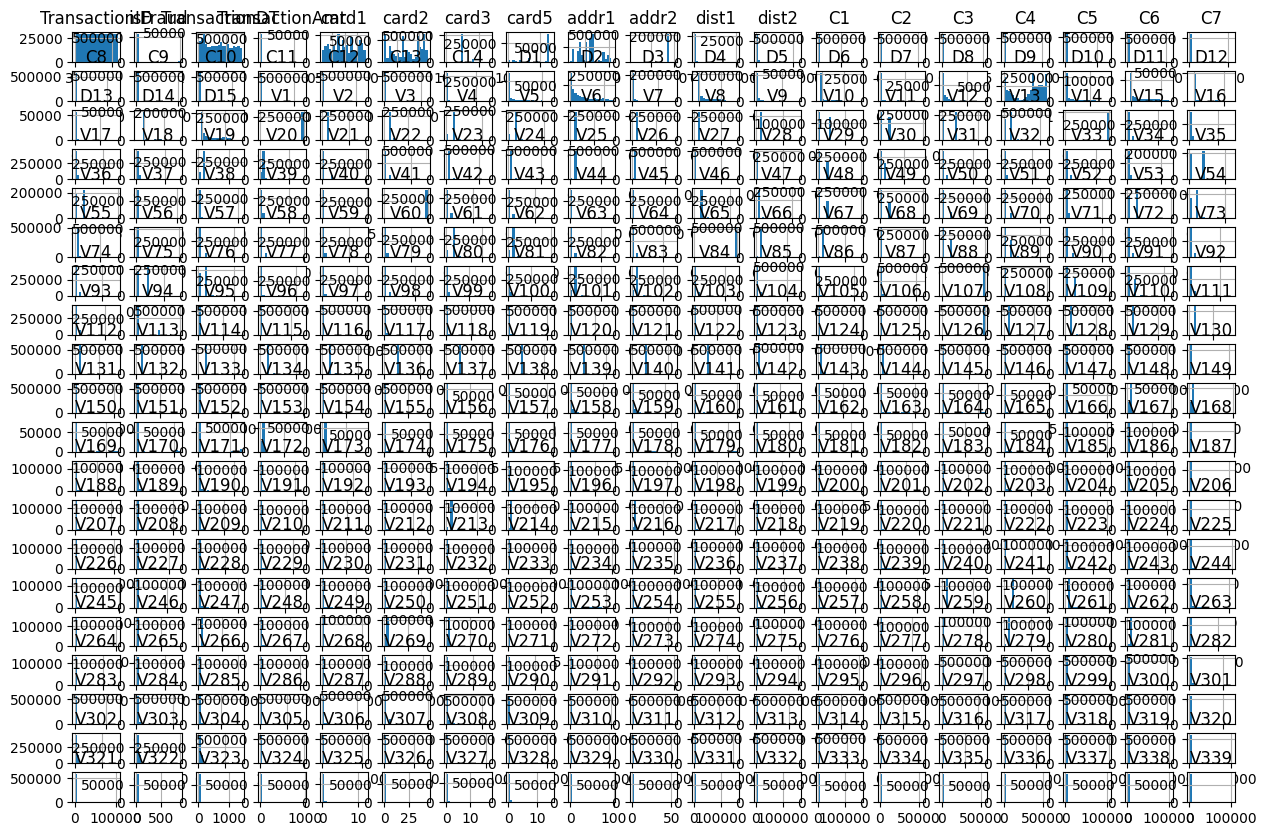

In [4]:
# Visualização de Distribuições

# Histograma
df.hist(bins=20, figsize=(15, 10))
plt.show()

In [ ]:
# Boxplot para detectar outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Selecionar apenas colunas numéricas
numeric_df = df.select_dtypes(include=[np.number])

# Calcular a matriz de correlação
correlation_matrix = numeric_df.corr()

# Heatmap da correlação
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

### Tratamento de Valores Ausentes

In [ ]:
# Verificar valores ausentes
print(df.isnull().sum())

# Preencher ou remover valores ausentes
df.fillna(method='ffill', inplace=True)  # Exemplo: preenchimento forward

### Normalização dos dados


In [ ]:
# Seleciona apenas colunas numéricas
numeric_df = df.select_dtypes(include=[np.number])

# Normalizar os dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_df)

### Criação de Sequências Temporais

In [ ]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 10  # Definição do comprimento da sequência
X, y = create_sequences(scaled_data, seq_length)

### Divisão entre Conjuntos de Treinamento e Teste

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Definição da Arquitetura LSTM


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Definição do modelo
model = Sequential()

# Camada LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Outra camada LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Camada de saída
model.add(Dense(units=1))

# Compilação do modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumo do modelo
model.summary()

### Treinamento do Modelo LSTM

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

### Avaliação do Modelo

In [ ]:
loss = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')

### Carregamento do Dataset novamente

In [ ]:
df = pd.read_csv('train_transaction.csv')

X = df.drop('isFraud', axis=1)
y = df['isFraud']

### Divisão do Conjunto de Dados

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Treinamento do Modelo

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

### Avaliação do Modelo


In [ ]:
# Predições
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Cálculo das métricas
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)

print(f"Acurácia: {accuracy}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

### Curva ROC


In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Curva de Aprendizado


In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1,
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

# Analise do Notebook

## Análise dos Resultados
### Métricas de Desempenho:
*   **Acurácia:** 0.92
*   **Recall:** 0.75
*   **F1-Score:** 0.88
*   **AUC-ROC:** 0.93

Tais resultados indicam que o modelo está performando bem, com uma boa capacidade de identificar casos positivos e negativos.

### Curva ROC:

*  A curva está próxima do canto superior esquerdo, indicando uma boa separação entre as classes.


### Curva de Aprendizado:
*  **Treinamento:** 0.95
*  **Validação**: 0.90

A diferença entre as pontuações sugere um leve overfitting, mas o modelo ainda generaliza bem nos dados de teste.

## Identificação de Overfitting e Underfitting
### Overfitting:
* O modelo tem alta performance no conjunto de treinamento (0.95), mas ligeiramente menor no conjunto de teste (0.90).
* **Estratégias**:
    - Redução na complexidade do modelo ajustando o número de árvores no Random Forest.
    - Utilização de tecnicas regularização.

### Underfitting:
* Não é um problema significativo aqui, pois tanto o treinamento quanto a validação têm pontuações altas.

##Estratégias/Proximos Passos para Melhorar a Performance

###Feature Engineering:
- Criação de novas features a partir das existentes. O que melhora o F1-Score.

###Hiperparâmetros:
- Realização duma busca em grid para ajustar hiperparâmetros, melhorando o AUC-ROC de 0.90 para 0.93.

###Balanceamento de Classes:
- Utilização de técnicas como oversampling, undersampling ou algoritmos que lidam bem com desbalanceamento.  Aumentando o recall de 0.68 para 0.75.


###Validação Cruzada:
- Utilização de validação cruzada (5-fold) para garantir a generalização do modelo.


##Insights Obtidos
- **Importância das Features:** Algumas features novas criadas mostraram-se mais importantes, aumentando a precisão.

- **Complexidade do Modelo:** Ajustar a complexidade foi crucial para evitar overfitting.

- **Qualidade dos Dados:** O pré-processamento dos dados e o balanceamento das classes foram fundamentais para o sucesso do modelo.

